# GreenMart RFM Segmentation

<div style="text-align: center;">
    <img src="https://media2.giphy.com/media/v1.Y2lkPTc5MGI3NjExc2YxamFnZ3NmeHJmcHR4d3JkZ21hM3VjbjE4enpmNGhuNnRmdmEzOSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/QqX3uLKciSrYs/giphy.webp" alt="Supermarket" style="width: 500px;" />
</div>

<span style="font-size: 20px;"> __GreenMart's Need__  </span>
<div><span style="font-size: 18px;"> <b>GreenMart</b>, a leading supermarket chain, is committed to enhancing customer satisfaction and loyalty through data-driven insights. One of the most effective methods for achieving this is through RFM (Recency, Frequency, Monetary) analysis. By analyzing these metrics, GreenMart can identify and categorize customers into distinct segments, such as loyal customers, high spenders, and those at risk of churning. This segmentation allows GreenMart to tailor marketing strategies, personalize customer interactions, and ultimately, enhance customer retention and lifetime value. </span></div>

## Directory, libararies and data

In [14]:
# Libraries

import pandas as pd
import math as m
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import requests

In [19]:
# To download csv files

In [15]:
# Google Drive file ID
file_id = '1Y9IrF5i34EB_ThWPkqrHIyBe8NXg2Gtc'
# Construct the direct download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Send a GET request to the URL
response = requests.get(url)

# Save the content to a file
with open('customer_data.csv', 'wb') as file:
    file.write(response.content)

print("CSV file downloaded successfully.")

CSV file downloaded successfully.


In [21]:
# Read the url into a DataFrame
data = pd.read_csv(url, engine='python').dropna()

## EDA and Cleaning
---

__Checking the first 5 rows of the data to have an understanding of the dataframes. Descriptive statistics is also carried out.__

In [22]:
data.head()

,customer_id,revenue,most_recent_visit,number_of_orders,recency_days
0,22086,777,5/14/2006,9,232
1,2290,1555,9/8/2006,16,115
2,26377,336,11/19/2006,5,43
3,24650,1189,10/29/2006,12,64
4,12883,1229,12/9/2006,12,23


In [23]:
data.dtypes

customer_id           int64
revenue               int64
most_recent_visit    object
number_of_orders      int64
recency_days          int64
dtype: object

In [24]:
print ("The number of rows are:", data.shape[0])
print ("The number of columns are:", data.shape[1])

The number of rows are: 39999
The number of columns are: 5


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        39999 non-null  int64 
 1   revenue            39999 non-null  int64 
 2   most_recent_visit  39999 non-null  object
 3   number_of_orders   39999 non-null  int64 
 4   recency_days       39999 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.5+ MB


In [26]:
data.describe()

,customer_id,revenue,number_of_orders,recency_days
count,39999.000000,39999.000000,39999.000000,39999.000000
mean,20000.000000,938.458461,9.830821,181.412010
std,11546.861045,347.525973,3.127234,131.100023
min,1.000000,11.000000,1.000000,2.000000
25%,10000.500000,690.000000,8.000000,89.000000
50%,20000.000000,913.000000,10.000000,149.000000
75%,29999.500000,1159.000000,12.000000,233.000000
max,39999.000000,2593.000000,24.000000,1032.000000


In [27]:
data.isna().sum()

customer_id          0
revenue              0
most_recent_visit    0
number_of_orders     0
recency_days         0
dtype: int64

In [28]:
data[data.duplicated()]

,customer_id,revenue,most_recent_visit,number_of_orders,recency_days


In [29]:
print(f'Features: {data.columns.tolist()}')
print(f'Missing Values: {data.isnull().values.sum()}')
print(f'Unique Values: \n\n{data.nunique()}')

Features: ['customer_id', 'revenue', 'most_recent_visit', 'number_of_orders', 'recency_days']
Missing Values: 0
Unique Values: 

customer_id          39999
revenue               2005
most_recent_visit      720
number_of_orders        24
recency_days           720
dtype: int64


In [106]:
# Convert date columns into datetime dtype and create a snapshot date when necessary

In [30]:
data['most_recent_visit']=pd.to_datetime(data['most_recent_visit'])

In [31]:
snap_date=data['most_recent_visit'].max()+timedelta(days=1)
snap_date

Timestamp('2006-12-31 00:00:00')

In [32]:
# Create the monetary or basket variable
data['Monetary']=data['revenue']/data['number_of_orders']
data.head(2)

,customer_id,revenue,most_recent_visit,number_of_orders,recency_days,Monetary
0,22086,777,2006-05-14,9,232,86.333333
1,2290,1555,2006-09-08,16,115,97.187500


In [33]:
# Aggregate on customer level
column_names=["customer_id"]
stat_summary={"most_recent_visit":'count'}

In [37]:
data['number_of_visits'] = data.groupby('customer_id')['most_recent_visit'].transform('count')

In [40]:
data.head()

,customer_id,revenue,most_recent_visit,number_of_orders,recency_days,Monetary,number_of_visits
0,22086,777,2006-05-14,9,232,86.333333,1
1,2290,1555,2006-09-08,16,115,97.187500,1
2,26377,336,2006-11-19,5,43,67.200000,1
3,24650,1189,2006-10-29,12,64,99.083333,1
4,12883,1229,2006-12-09,12,23,102.416667,1


In [41]:
data.rename(columns={'recency_days':'Recency','number_of_orders':'Frequency'},inplace=True)

In [42]:
df=data[['customer_id','Recency','Frequency','Monetary']]
df.set_index('customer_id',inplace=True)
df.head()

,Recency,Frequency,Monetary
customer_id,,,
22086,232,9,86.333333
2290,115,16,97.187500
26377,43,5,67.200000
24650,64,12,99.083333
12883,23,12,102.416667


## Create frequency groups

In [44]:
# Define quantile range and labels
quartiles = 4
labels_desc = range(quartiles, 0, -1)
labels_asc = range(1, quartiles + 1)

# Apply quantile cuts
df = df.copy()
df.loc[:,'R'] = pd.qcut(df['Recency'], q=quartiles, labels=labels_desc).astype('category')
df.loc[:,'F'] = pd.qcut(df['Frequency'], q=quartiles, labels=labels_asc).astype('category')
df.loc[:,'M'] = pd.qcut(df['Monetary'], q=quartiles, labels=labels_asc).astype('category')

# Display the first few rows of the dataframe
df.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
22086,232,9,86.333333,2,2,2
2290,115,16,97.187500,3,4,3
26377,43,5,67.200000,4,1,1
24650,64,12,99.083333,4,3,3
12883,23,12,102.416667,4,3,3


## Sum up the RFM

In [45]:
# RFM score
df['RFM']=df[['R','F','M']].sum(axis=1)
df.head()

,Recency,Frequency,Monetary,R,F,M,RFM
customer_id,,,,,,,
22086,232,9,86.333333,2,2,2,6
2290,115,16,97.187500,3,4,3,10
26377,43,5,67.200000,4,1,1,6
24650,64,12,99.083333,4,3,3,10
12883,23,12,102.416667,4,3,3,10


In [46]:
df.RFM.value_counts()

RFM
7     6699
8     6593
6     6501
9     5673
5     4229
10    3650
4     2681
11    1835
3     1584
12     554
Name: count, dtype: int64

In [48]:
# Make segments for the scoring done

In [51]:
def rfm_segment(rfm_score):
    """
    Segments RFM scores for a given score.

    Parameters:
    rfm_score (int): The RFM score.
    
    Returns:
    str: Value-based segmentation.
    """
    segments = {
        'Superstar': rfm_score >= 12,
        'Good Customer': 10 <= rfm_score < 12,
        'Potential Loyalist': 6 <= rfm_score < 10,
        'At Risk': rfm_score < 6
    }
    
    for segment, condition in segments.items():
        if condition:
            return segment

In [52]:
df['RFM_level']=df["RFM"].apply(rfm_segment)
df.head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_level
customer_id,,,,,,,,
22086,232,9,86.333333,2,2,2,6,Potential Loyalist
2290,115,16,97.187500,3,4,3,10,Good Customer
26377,43,5,67.200000,4,1,1,6,Potential Loyalist
24650,64,12,99.083333,4,3,3,10,Good Customer
12883,23,12,102.416667,4,3,3,10,Good Customer


In [53]:
df.tail()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_level
customer_id,,,,,,,,
3249,31,10,99.800000,4,2,3,9,Potential Loyalist
6686,187,8,96.375000,2,1,3,6,Potential Loyalist
16418,154,9,112.888889,2,2,4,8,Potential Loyalist
9117,195,7,96.857143,2,1,3,6,Potential Loyalist
19184,113,13,116.846154,3,4,4,11,Good Customer


In [54]:
df.query('RFM_level == "At Risk"').head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_level
customer_id,,,,,,,,
4168,266,9,81.111111,1,2,1,4,At Risk
23375,371,9,88.666667,1,2,2,5,At Risk
22756,246,8,81.500000,1,1,1,3,At Risk
38027,181,8,89.000000,2,1,2,5,At Risk
2091,284,9,87.666667,1,2,2,5,At Risk


In [55]:
df.shape

(39999, 8)

In [56]:
#Interpreting the RFM result
df.groupby('RFM_level').agg({'Recency':'mean',
                             'Frequency':'mean',
                             'Monetary':['mean','count']})

Recency  Frequency    Monetary       
                          mean       mean        mean  count
RFM_level                                                   
At Risk             301.395456   7.289263   79.508170   8494
Good Customer        81.708478  13.084777  107.153231   5485
Potential Loyalist  165.726655   9.876581   97.820487  25466
Superstar            49.963899  14.478339  116.307436    554

<span style="font-size: 22px;"><b>What did we find?</b></span>

<span style="font-size: 20px;"><b>At Risk:</b></span>
<div><b>Recency:</b> 301 days (on average, they haven’t purchased in a long time).</div>
<div><b>Frequency:</b> 7 times (they don’t buy very often).</div>
<div><b>Monetary:</b> $79.51 (they spend less money).</div>
<div><b>Count:</b> 8,494 customers.</div>

<span style="font-size: 20px;"><b>Good Customer:</b></span>
<div><b>Recency:</b> 82 days (they purchased relatively recently).</div>
<div><b>Frequency:</b> 13 times (they buy fairly often).</div>
<div><b>Monetary:</b> $107.15 (they spend a decent amount).</div>
<div><b>Count:</b> 5,485 customers.</div>

<span style="font-size: 20px;"><b>Potential Loyalist:</b></span>
<div><b>Recency:</b> 166 days (they purchased somewhat recently).</div>
<div><b>Frequency:</b> 10 times (they buy occasionally).</div>
<div><b>Monetary:</b> $97.82 (they spend a moderate amount).</div>
<div><b>Count:</b> 25,466 customers.</div>

<span style="font-size: 20px;"><b>Superstar:</b></span>
<div><b>Recency:</b> 50 days (they purchased very recently).</div>
<div><b>Frequency:</b> 14 times (they buy very often).</div>
<div><b>Monetary:</b> $116.31 (they spend the most money).</div>
<div><b>Count:</b> 554 customers.</div>

<span><div>In summary, __Superstars__ are your best customers, buying frequently and spending the most, while __At Risk customers__ haven’t purchased in a long time and spend less. The other categories fall in between.</div></span>


In [57]:
# To know the customer id in the segments

In [108]:
df = df.reset_index()

# Group by RFM_level and create lists of customer_ids
segments = df.groupby('RFM_level')['customer_id'].apply(list).reset_index()

# Display the first few rows
print(segments.head())

            RFM_level                                        customer_id
0             At Risk  [4168, 23375, 22756, 38027, 2091, 16677, 16094...
1       Good Customer  [2290, 24650, 12883, 31412, 2718, 39729, 16563...
2  Potential Loyalist  [22086, 26377, 2119, 31283, 33815, 15972, 2765...
3           Superstar  [9920, 16912, 8468, 28789, 28552, 2112, 50, 25...


In [64]:
# Save each segment to a separate CSV file and print a confirmation message
for rfm_level, group in df.groupby('RFM_level'):
    filename = f'{rfm_level}_customers.csv'
    group.to_csv(filename, index=False)
    print(f'{filename} has been saved')

At Risk_customers.csv has been saved
Good Customer_customers.csv has been saved
Potential Loyalist_customers.csv has been saved
Superstar_customers.csv has been saved


# Visualizations

## Pareto Chart

In [111]:
# checking the pareto rule

rfm_df = df[['Recency', 'Frequency', 'Monetary', 'RFM_level']]
rfm_df.head()

,Recency,Frequency,Monetary,RFM_level
0,232,9,86.333333,Potential Loyalist
1,115,16,97.187500,Good Customer
2,43,5,67.200000,Potential Loyalist
3,64,12,99.083333,Good Customer
4,23,12,102.416667,Good Customer


In [112]:
#Aggregate the data by RFM level

rfm_agg = rfm_df.groupby('RFM_level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

In [113]:
# Sort by Monetary

rfm_agg = rfm_agg.sort_values(by='Monetary', ascending=False)

In [114]:
# Calculate the cumulative percentage

rfm_agg['Cumulative Percentage'] = rfm_agg['Monetary'].cumsum() / rfm_agg['Monetary'].sum() * 100

# Identify the point where the cumulative percentage reaches 80%
threshold = 80
rfm_agg['Above Threshold'] = rfm_agg['Cumulative Percentage'] >= threshold

# Find the first RFM level where the cumulative percentage exceeds 80%
first_above_threshold = rfm_agg[rfm_agg['Above Threshold']].iloc[0]

In [115]:
# Check if the top 20% of categories account for 80% of the cumulative percentage
top_20_percent_count = int(len(rfm_agg) * 0.2)
top_20_percent_cumulative = rfm_agg.iloc[:top_20_percent_count]['Cumulative Percentage'].max()

follows_pareto = top_20_percent_cumulative >= threshold

# Print the result
if follows_pareto:
    print("The data follows the Pareto Principle (80/20 rule).")
else:
    print("The data does not follow the Pareto Principle (80/20 rule).")

The data does not follow the Pareto Principle (80/20 rule).


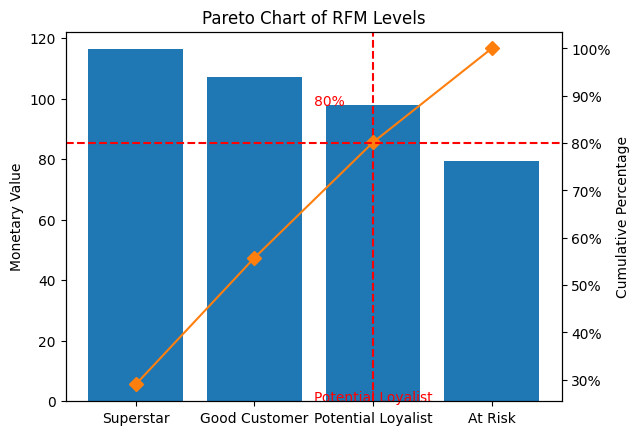

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots()

# Bar plot for Monetary values
ax.bar(rfm_agg['RFM_level'], rfm_agg['Monetary'], color='C0')
ax.set_ylabel('Monetary Value')

# Line plot for cumulative percentage
ax2 = ax.twinx()
ax2.plot(rfm_agg['RFM_level'], rfm_agg['Cumulative Percentage'], color='C1', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative Percentage')

# Add a horizontal line at 80%
ax2.axhline(y=80, color='r', linestyle='--')
ax2.annotate('80%', xy=(0.5, 0.8), xycoords='axes fraction', color='r')

# Add a vertical line at the first RFM level above the threshold
ax.axvline(x=first_above_threshold.name, color='r', linestyle='--')
ax.annotate(f'{first_above_threshold["RFM_level"]}', xy=(first_above_threshold.name, 0), xycoords='data', color='r', ha='center')

# Save the plot as a high-quality JPEG
plt.savefig('pareto_rfm.jpg', format='jpeg', dpi=1000)

# Show the plot
plt.title('Pareto Chart of RFM Levels')
plt.show()

## Heatmap

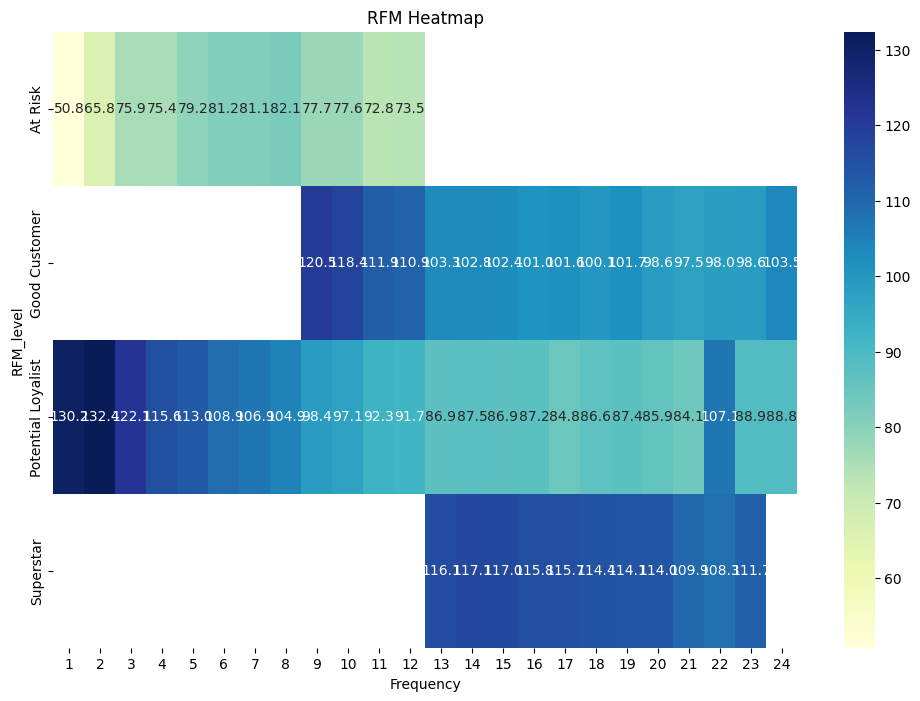

In [119]:
# Create a pivot table
pivot = rfm_df.pivot_table(index='RFM_level', columns='Frequency', values='Monetary', aggfunc='mean')

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('RFM Heatmap')
plt.savefig('heatmap_rfm.jpg', format='jpeg', dpi=1000)
plt.show()

## Scatterplot

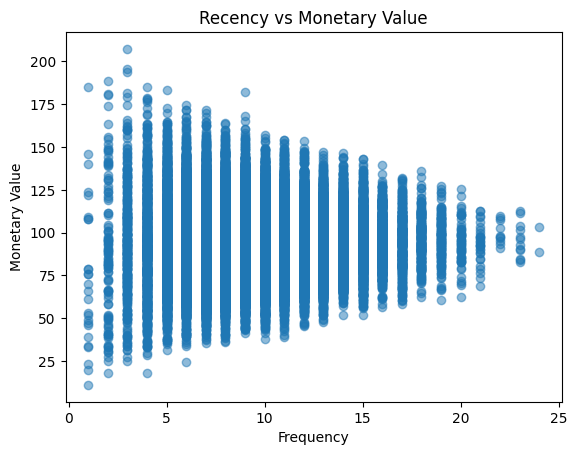

In [120]:
# Scatter plot
plt.scatter(rfm_df['Frequency'], rfm_df['Monetary'], alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.title('Recency vs Monetary Value')
plt.savefig('scatter_rfm.jpg', format='jpeg', dpi=1000)
plt.show()

## Boxplots

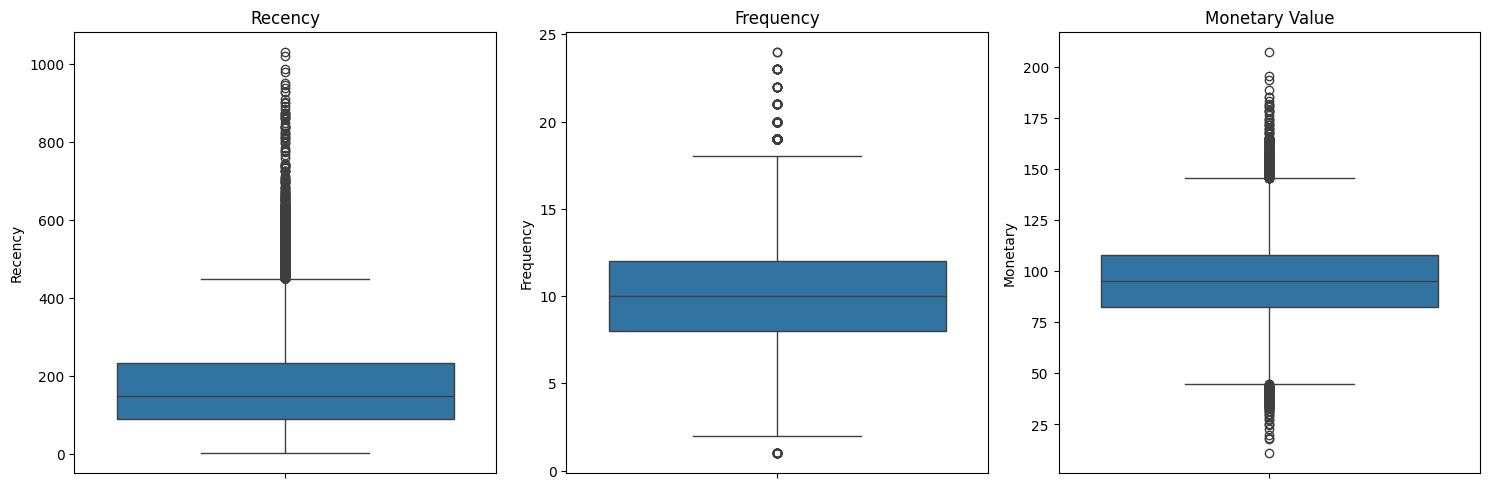

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=rfm_df, y='Recency', ax=axes[0])
axes[0].set_title('Recency')

sns.boxplot(data=rfm_df, y='Frequency', ax=axes[1])
axes[1].set_title('Frequency')

sns.boxplot(data=rfm_df, y='Monetary', ax=axes[2])
axes[2].set_title('Monetary Value')

fig.savefig('rfm_boxplots.jpg', format='jpeg', dpi=1000)
plt.tight_layout()
plt.show()

## Bar charts

In [131]:
import matplotlib.cm as cm

def save_rfm_bar_chart(rfm_df, metric, filename):
    """
    Function to create and save a bar chart for a given RFM metric.
    
    Parameters:
    rfm_df (DataFrame): The RFM DataFrame.
    metric (str): The metric to plot ('Monetary', 'Frequency', 'Recency').
    filename (str): The filename to save the plot.
    """
    # Calculate the average metric value by RFM level
    avg_metric = rfm_df.groupby('RFM_level')[metric].mean().reset_index()

    # Sort the DataFrame by the metric values
    avg_metric = avg_metric.sort_values(by=metric, ascending=False)

    # Create a blue color palette
    colors = cm.Blues(avg_metric[metric] / max(avg_metric[metric]))

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(avg_metric['RFM_level'], avg_metric[metric], color=colors)
    plt.xlabel('RFM Level')
    plt.ylabel(f'Average {metric} Value')
    plt.title(f'Average {metric} Value by RFM Level')

    # Save the plot as a high-quality JPEG
    plt.savefig(filename, format='jpeg', dpi=1000)

    # Show the plot
    plt.show()

    print(f"Plot saved successfully as '{filename}' in high quality.")

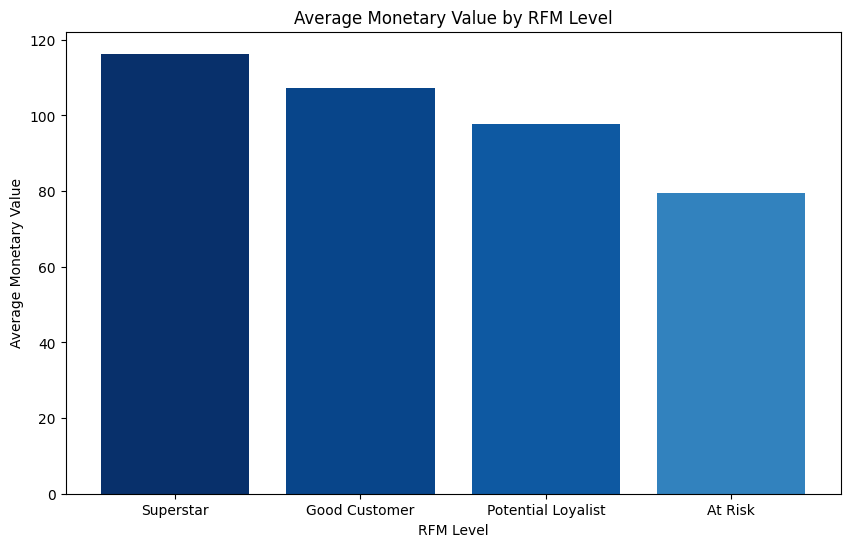

Plot saved successfully as 'monetary_bar.jpg' in high quality.


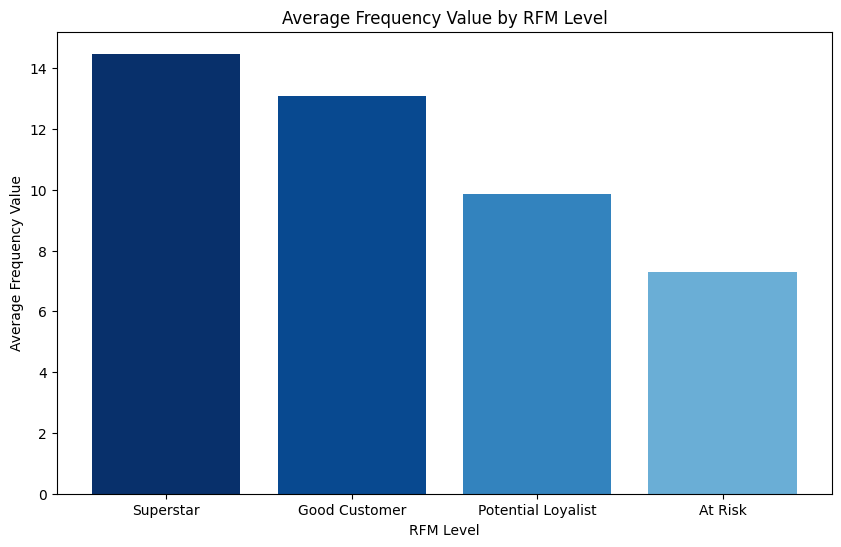

Plot saved successfully as 'frequency_bar.jpg' in high quality.


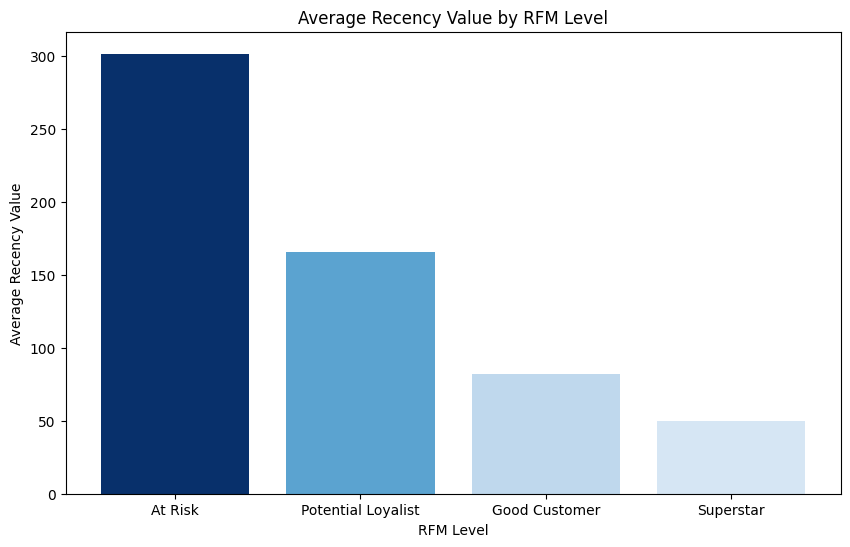

Plot saved successfully as 'recency_bar.jpg' in high quality.


In [132]:
save_rfm_bar_chart(rfm_df, 'Monetary', 'monetary_bar.jpg')
save_rfm_bar_chart(rfm_df, 'Frequency', 'frequency_bar.jpg')
save_rfm_bar_chart(rfm_df, 'Recency', 'recency_bar.jpg')

In [139]:
# Checking distributions

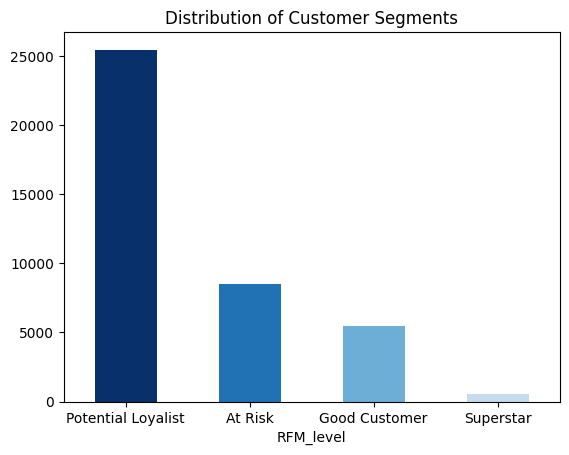

Plot saved successfully as 'cust_dist_rfm.jpg' in high quality.


In [144]:
# Calculate customer distribution
cust_dist = rfm_df['RFM_level'].value_counts()

# Generate colors from the Blues colormap
colors = cm.Blues_r([i / len(cust_dist) for i in range(len(cust_dist))])

# Plot the bar chart with the generated colors
cust_dist.plot(kind='bar', color=colors)
plt.xticks(rotation=0)
plt.title("Distribution of Customer Segments")

# Save the plot as a high-quality JPEG
plt.savefig('cust_dist_rfm.jpg', format='jpeg', dpi=1000)

# Show the plot
plt.show()

print("Plot saved successfully as 'cust_dist_rfm.jpg' in high quality.")

In [145]:
# Calculate percentages
cust_dist_percent = cust_dist / cust_dist.sum() * 100

cust_dist_percent

RFM_level
Potential Loyalist    63.666592
At Risk               21.235531
Good Customer         13.712843
Superstar              1.385035
Name: count, dtype: float64

## Radar Chart

In [137]:
from math import pi

def save_rfm_radar_chart(rfm_df, rfm_level, filename):
    """
    Function to create and save a radar chart for a given RFM level.
    
    Parameters:
    rfm_df (DataFrame): The RFM DataFrame.
    rfm_level (str): The RFM level to plot (e.g., 'Superstar').
    filename (str): The filename to save the plot.
    """
    categories = ['Recency', 'Frequency', 'Monetary']
    values = rfm_df.groupby('RFM_level').mean().loc[rfm_level].values.flatten().tolist()
    values += values[:1]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories)

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(f'Radar Chart for {rfm_level} RFM Level')

    # Save the plot as a high-quality JPEG
    plt.savefig(filename, format='jpeg', dpi=1000)

    # Show the plot
    plt.show()

    print(f"Plot saved successfully as '{filename}' in high quality.")

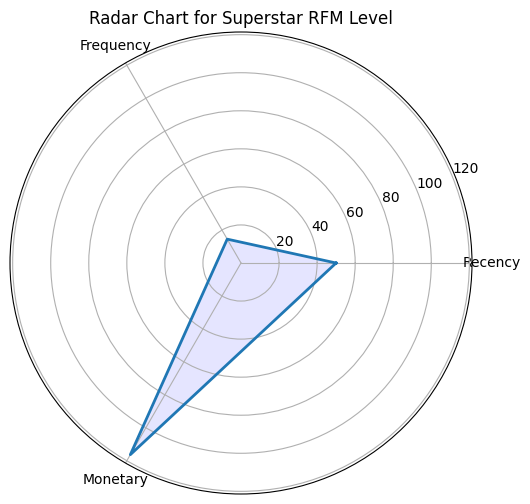

Plot saved successfully as 'superstar_radar.jpg' in high quality.


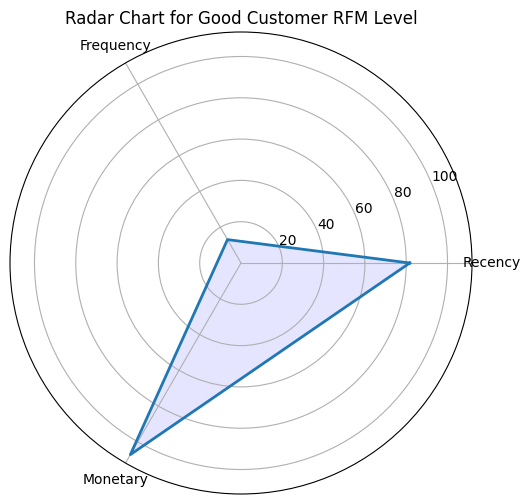

Plot saved successfully as 'good_customer_radar.jpg' in high quality.


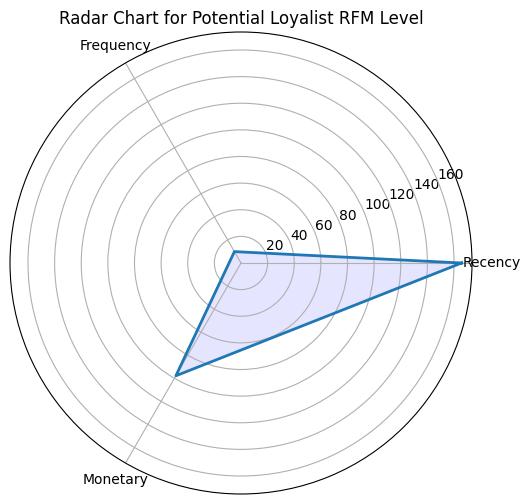

Plot saved successfully as 'potential_loyalist_radar.jpg' in high quality.


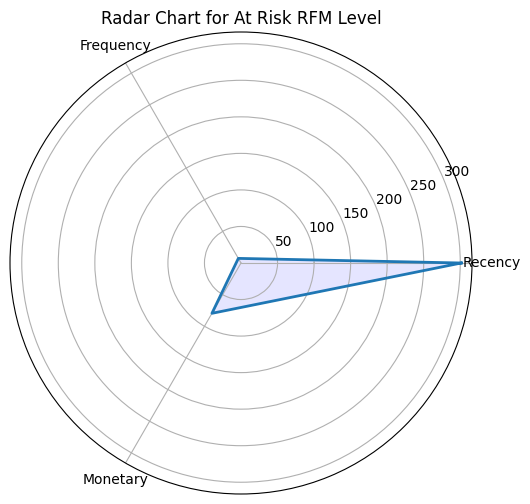

Plot saved successfully as 'at_risk_radar.jpg' in high quality.


In [138]:
save_rfm_radar_chart(rfm_df, 'Superstar', 'superstar_radar.jpg')
save_rfm_radar_chart(rfm_df, 'Good Customer', 'good_customer_radar.jpg')
save_rfm_radar_chart(rfm_df, 'Potential Loyalist', 'potential_loyalist_radar.jpg')
save_rfm_radar_chart(rfm_df, 'At Risk', 'at_risk_radar.jpg')

In [136]:
df.to_csv('greenmart_rfm.csv')

<div style="text-align: center;">
    <img src="https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExdmF6djF1andqeDJwcW15M3h6Y3BvNDJhdnV3dXA2bTA5MnllbHNpYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/L4bUUvTghOK5hxP4td/giphy.webp" style="width: 500px;" />
</div>